In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from sklearn.model_selection import train_test_split

from scipy.optimize import leastsq

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
def info(df, head=True):
    print("Type: ", type(df))
    print("Shape: ", df.shape)
    print("Columns: ", df.columns)
    if head:
        display(df.head())
    else:
        display(df)

def corr_vis(df, features, meas='AVERAGEKWH_raw'):
    '''
    Displays a corrrelation chart for the  specified features in the edf
    '''
    ## Create a blank dataframe that calculates all the correlations to TOG
    vis = pd.DataFrame()
    vis['feature'] = features
    vis['spearman'] = [df[f].corr(df[meas], 'spearman') for f in features]
    #[print(str(features[f]) + ": " + str(spr['spearman'][f])) for f in range(len(features))]
    
    vis = vis.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=vis, y='feature', x='spearman', orient='h')
    
    ## Chart design
    ax.set(xlabel='correlation')
    ax.set(title='Correlation of all features to {meas}'.format(meas=meas)) 
    return vis

# Importing GeoDataFrames

California Counties and Boundarise sourced from https://data.ca.gov/dataset/ca-geographic-boundaries

In [ ]:
base = "/datasets/team-red-residential-energy-consumption/datasets/team-red-residential-energy-consumption/Data/"

In [ ]:
cleaned_monthly_with_zip_and_citis_fn = base + "cleaned_data/all-pge-with-nrel/transformed_pge-energy-consumption-with-nrel-solar_2013-2019_136968x35.shp"
zip_cities_monthly_pge_gdf = gpd.read_file(cleaned_monthly_with_zip_and_citis_fn)


In [ ]:
rename_mapper ={
    'TOTALCUSTO': 'TOTALCUSTO_raw',
    'TOTALKWH_r': 'TOTALKWH_raw',
    'AVERAGEKWH': 'AVERAGEKWH_raw',
    'TOTALTHERM': 'TOTALTHERM_raw',
    'AVERAGETHE': 'AVERAGETHERM_raw',
    'Temperatur': 'Temperature_raw', 
    'Solar Zeni': 'Solar_Zenith_Angle_raw',
    'TOTALCUS_1': 'TOTALCUS_std', 
    'TOTALKWH_s': 'TOTALKWH_std', 
    'AVERAGEK_1': 'AVERAGEKWH_std', 
    'TOTALTHE_1': 'TOTALTHERM_std', 
    'AVERAGET_1': 'AVERAGETHERM_std',
    'Wind Spe_1': 'Wind_Speed_std', 
    'Temperat_1': 'Temperature_std',
    'Solar Ze_1': 'Solar_Zenith_Angle_std', 
}
zip_cities_monthly_pge_gdf = zip_cities_monthly_pge_gdf.rename(rename_mapper, axis=1)
zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'])
zip_cities_monthly_pge_gdf['Temperature_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Temperature_raw'])

In [ ]:
info(zip_cities_monthly_pge_gdf)

Type:  <class 'geopandas.geodataframe.GeoDataFrame'>
Shape:  (136968, 36)
Columns:  Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')


,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
0,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-01-01,1,2013,...,-0.590525,-0.46156,-0.348278,-1.198043,-1.373894,-0.709183,-1.894812,-2.255195,1.283431,POINT (-120.84510 39.17703)
1,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-02-01,2,2013,...,-0.590525,-0.46156,-0.348278,-0.621567,-0.990437,-0.041747,-1.837832,-1.881118,0.787489,POINT (-120.84510 39.17703)
2,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-03-01,3,2013,...,-0.590525,-0.46156,-0.348278,-0.341841,0.775179,-0.762886,-1.841878,-1.193114,0.089457,POINT (-120.84510 39.17703)
3,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-04-01,4,2013,...,-0.590525,-0.46156,-0.348278,0.639561,0.659686,0.529226,-1.828112,-0.713287,-0.643372,POINT (-120.84510 39.17703)
4,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-05-01,5,2013,...,0.278279,-0.46156,-0.348278,0.985208,0.972799,0.807632,-1.802339,-0.107015,-1.200288,POINT (-120.84510 39.17703)


### Sanity check geographic plots

#### California should look like California

#### PG&E dataset matches pg&e customers
PG&E service area reference: https://www.pge.com/mybusiness/customerservice/otherrequests/treetrimming/territory/

## Overlaying PG&E/NREL in Bay Area Only

Bay Area traditionally consists of [9 counties](https://wikitravel.org/en/Bay_Area_(California)).

<img src='https://wikitravel.org/upload/shared//thumb/b/bc/Bayarea_map.png/900px-Bayarea_map.png' style="width: 300px;">


We will define "Bay Area" as a box that encloses the following coordinates `(lat, long)`:

- South West corner: `(36.897966, -123.433313)`

- North East corner: `(38.593263, -121.381268)`

With these coordinates, we'll need to only consider data in the PG&E/NREL dataset that falls within this region.

In [ ]:
approximate_bay_area_center_lat = 39.5769252
approximate_bay_area_center_long = -122.2833322

## for subsetting the ca counties
bay_area_south_west_lat  = 36.897966    ## vertical
bay_area_south_west_long = -123.433313 ## horizontal
bay_area_north_east_lat  = 38.593263    ## vertical --> closer to north pole => higher values
bay_area_north_east_long = -121.381268 ## horizontal --> west long < east long. west is more negative

## for plotting boundaries
bay_area_limit_south_west_lat  = 36.897966    ## vertical
bay_area_limit_south_west_long = -123.75 ## horizontal
bay_area_limit_north_east_lat  = 38.9    ## vertical --> closer to north pole => higher values
bay_area_limit_north_east_long = -121.2 ## horizontal --> west long < east long. west is more negative


### Filtering Bay Area Only Data


#### Boxing the CA Counties Data

#### Boxing the PG&E/NREL Data

In [ ]:
zip_cities_monthly_pge_gdf.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')

In [ ]:
## subset south west
bay_area_monthly_pge_nrel = zip_cities_monthly_pge_gdf[ (bay_area_south_west_long <= zip_cities_monthly_pge_gdf['longitude']) & (bay_area_south_west_lat <= zip_cities_monthly_pge_gdf['latitude']) ]

## subst north east
bay_area_monthly_pge_nrel = bay_area_monthly_pge_nrel[ (bay_area_monthly_pge_nrel['longitude'] <= bay_area_north_east_long) & (bay_area_monthly_pge_nrel['latitude'] <= bay_area_north_east_lat) ]


In [ ]:
## Viewing how many measurements are the box
bay_area_monthly_pge_nrel.shape

(56683, 36)

In [ ]:
bay_area_monthly_pge_nrel.columns
raw_cols = ["MONTH", 'YEAR', 'zip', 'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw']
bay_area_monthly_pge_nrel_raw = bay_area_monthly_pge_nrel[raw_cols]
bay_area_monthly_pge_nrel_raw.head()

,MONTH,YEAR,zip,TOTALCUSTO_raw,TOTALKWH_raw,AVERAGEKWH_raw,TOTALTHERM_raw,AVERAGETHERM_raw,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw
94,1,2013,94564,6727,3787580,563,0,0,116.13037634408602,29.18010752688172,222.91935483870967,2.123252688172044,7.276882,105.581747
95,2,2013,94564,6725,3086143,459,0,0,162.37946428571428,38.666666666666664,262.79017857142856,2.1078869047619047,9.022321,99.577827
96,3,2013,94564,6715,3091798,460,0,0,190.54569892473117,70.01209677419355,211.2741935483871,2.017607526881722,11.189516,91.109973
97,1,2013,94564,6166,0,0,562494,91,116.13037634408602,29.18010752688172,222.91935483870967,2.123252688172044,7.276882,105.581747
98,2,2013,94564,6172,0,0,388246,63,162.37946428571428,38.666666666666664,262.79017857142856,2.1078869047619047,9.022321,99.577827


In [ ]:
measurment_cols = ["MONTH",'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std']

,feature,spearman
14,AVERAGEKWH_std,-0.773815
3,AVERAGEKWH_raw,-0.773815
2,TOTALKWH_raw,-0.773815
13,TOTALKWH_std,-0.773815
10,Temperature_raw,-0.186410
21,Temperature_std,-0.186410
17,GHI_std,-0.171452
19,DNI_std,-0.164958
8,DNI_raw,-0.162345
18,DHI_std,-0.128625


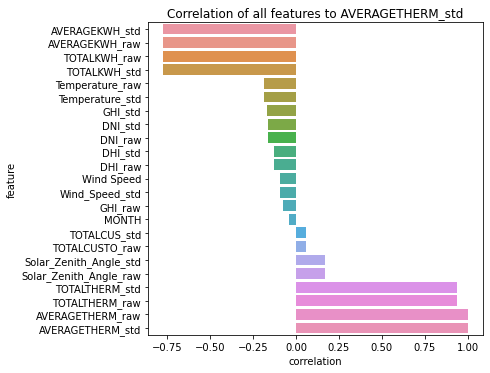

In [ ]:
corr_vis(bay_area_monthly_pge_nrel, measurment_cols, meas='AVERAGETHERM_std')

In [ ]:
def lag_by_zipcode(full_df, L, zipcode, desired_cols=['TOTALKWH_raw', 'AVERAGEKWH_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed', 'Temperature_raw', 'Solar_Zenith_Angle_raw'],
                                       zip_col='zip',
                                       time_col='DATE'):
    subsetted_zip = full_df[full_df[zip_col] == zipcode].sort_values(by=time_col)

    ## Lag for the columns we want
    additional_columns = []
    for lag in range(1,L+1):
        for c in desired_cols:
            new_col_name = c + " lag l=%i"%(lag)
            additional_columns.append(new_col_name)
            subsetted_zip[new_col_name] = subsetted_zip[c].shift(lag).tolist()
    
#     print(merged.columns)
    return subsetted_zip

    

In [ ]:
X_cols = ['MONTH','YEAR', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed', 'Temperature_raw', 'Solar_Zenith_Angle_raw' ]
bay_area_monthly_elec_pge_nrel = bay_area_monthly_pge_nrel[bay_area_monthly_pge_nrel['TOTALTHERM_raw']==0].drop_duplicates()

## Cutting out using our engineering judgement
bay_area_monthly_elec_pge_nrel = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['zip'] != 94301] ## Cut out Palo Alto, which only has 16 measurements
bay_area_monthly_elec_pge_nrel = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['zip'] != 94035] ## Cut out Mountain View which only has 16 measurements

bay_area_monthly_elec_pge_nrel_clean = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['TOTALKWH_std'] < 10]



In [ ]:
bay_area_monthly_elec_pge_nrel_clean.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')

In [ ]:
## lag for the columns we want
concatted = pd.DataFrame()
i = 1
L = 3
PROGRESS_CHECKPOINT = 5
for zipcode in sorted(bay_area_monthly_elec_pge_nrel_clean['zip'].unique()):
    if i % PROGRESS_CHECKPOINT == 0:
        print("PROGRSS: #{i} - {zipcode}".format(i=i, zipcode=zipcode))
    to_concat = lag_by_zipcode(bay_area_monthly_elec_pge_nrel_clean, L, zipcode, zip_col='zip', time_col='DATE')
    concatted = pd.concat([concatted, to_concat])
    concatted.to_csv(base + 'cleaned_data/DEEPNOTE_CREATED_lagged_{L}_BA-monthly-elec-pge-nrel-clean.csv'.format(L=L))
    i+=1

PROGRSS: #5 - 94015
PROGRSS: #10 - 94022
PROGRSS: #15 - 94030
PROGRSS: #20 - 94043
PROGRSS: #25 - 94063
PROGRSS: #30 - 94080
PROGRSS: #35 - 94102
PROGRSS: #40 - 94108
PROGRSS: #45 - 94114
PROGRSS: #50 - 94121
PROGRSS: #55 - 94129
PROGRSS: #60 - 94134
PROGRSS: #65 - 94401
PROGRSS: #70 - 94505
PROGRSS: #75 - 94510
PROGRSS: #80 - 94517
PROGRSS: #85 - 94523
PROGRSS: #90 - 94531
PROGRSS: #95 - 94538
PROGRSS: #100 - 94545
PROGRSS: #105 - 94550
PROGRSS: #110 - 94556
PROGRSS: #115 - 94562
PROGRSS: #120 - 94568
PROGRSS: #125 - 94574
PROGRSS: #130 - 94580
PROGRSS: #135 - 94587
PROGRSS: #140 - 94595
PROGRSS: #145 - 94601
PROGRSS: #150 - 94607
PROGRSS: #155 - 94612
PROGRSS: #160 - 94702
PROGRSS: #165 - 94707
PROGRSS: #170 - 94801
PROGRSS: #175 - 94901
PROGRSS: #180 - 94923
PROGRSS: #185 - 94930
PROGRSS: #190 - 94939
PROGRSS: #195 - 94947
PROGRSS: #200 - 94956
PROGRSS: #205 - 94965
PROGRSS: #210 - 95002
PROGRSS: #215 - 95008
PROGRSS: #220 - 95018
PROGRSS: #225 - 95033
PROGRSS: #230 - 95046
PROGRSS:

In [ ]:
L=3
lagged_bame_pnc = pd.read_csv(base + 'cleaned_data/DEEPNOTE_CREATED_lagged_{L}_BA-monthly-elec-pge-nrel-clean.csv'.format(L=L))


In [ ]:
lagged_bame_pnc_dropna = lagged_bame_pnc.dropna()
lagged_bame_pnc_dropna.columns

Index(['Unnamed: 0', 'zip', 'city', 'state', 'latitude', 'longitude',
       'timezone', 'dst', 'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL',
       'COMBINED', 'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw',
       'TOTALTHERM_raw', 'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw',
       'Wind Speed', 'Temperature_raw', 'Solar_Zenith_Angle_raw',
       'TOTALCUS_std', 'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std',
       'AVERAGETHERM_std', 'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std',
       'Temperature_std', 'Solar_Zenith_Angle_std', 'geometry',
       'TOTALKWH_raw lag l=1', 'AVERAGEKWH_raw lag l=1', 'GHI_raw lag l=1',
       'DHI_raw lag l=1', 'DNI_raw lag l=1', 'Wind Speed lag l=1',
       'Temperature_raw lag l=1', 'Solar_Zenith_Angle_raw lag l=1',
       'TOTALKWH_raw lag l=2', 'AVERAGEKWH_raw lag l=2', 'GHI_raw lag l=2',
       'DHI_raw lag l=2', 'DNI_raw lag l=2', 'Wind Speed lag l=2',
       'Temperature_raw lag l=2', 'Solar_Zenith_Angle_raw lag l=2',
    

In [ ]:
## targetted_y can be changed to predict other values,
targetted_y = 'AVERAGEKWH_raw'
elec_Y_train = lagged_bame_pnc_dropna[targetted_y]

## Last step before passing data to our model (what to include)
X_cols = ['MONTH','YEAR', 'AVERAGEKWH_raw lag l=1', 'GHI_raw lag l=1',
       'DHI_raw lag l=1', 'DNI_raw lag l=1', 'Wind Speed lag l=1',
       'Temperature_raw lag l=1', 'Solar_Zenith_Angle_raw lag l=1',
        'AVERAGEKWH_raw lag l=2', 'GHI_raw lag l=2',
       'DHI_raw lag l=2', 'DNI_raw lag l=2', 'Wind Speed lag l=2',
       'Temperature_raw lag l=2', 'Solar_Zenith_Angle_raw lag l=2',
        'AVERAGEKWH_raw lag l=3', 'GHI_raw lag l=3',
       'DHI_raw lag l=3', 'DNI_raw lag l=3', 'Wind Speed lag l=3',
       'Temperature_raw lag l=3', 'Solar_Zenith_Angle_raw lag l=3' ]
elec_X_train = lagged_bame_pnc_dropna[X_cols]

In [ ]:
elec_X_train.head()

,MONTH,YEAR,AVERAGEKWH_raw lag l=1,GHI_raw lag l=1,DHI_raw lag l=1,DNI_raw lag l=1,Wind Speed lag l=1,Temperature_raw lag l=1,Solar_Zenith_Angle_raw lag l=1,AVERAGEKWH_raw lag l=2,...,Wind Speed lag l=2,Temperature_raw lag l=2,Solar_Zenith_Angle_raw lag l=2,AVERAGEKWH_raw lag l=3,GHI_raw lag l=3,DHI_raw lag l=3,DNI_raw lag l=3,Wind Speed lag l=3,Temperature_raw lag l=3,Solar_Zenith_Angle_raw lag l=3
3,4,2013,455.0,195.715054,71.255376,216.329301,3.340323,11.181452,91.103266,456.0,...,3.429167,9.815476,99.517798,555.0,118.551075,30.461022,220.584677,3.564247,9.044355,105.478320
4,5,2013,407.0,284.418056,64.431944,334.995833,3.858194,12.713889,82.265542,455.0,...,3.340323,11.181452,91.103266,456.0,166.961310,39.181548,269.005952,3.429167,9.815476,99.517798
5,6,2013,407.0,311.571237,71.837366,346.986559,4.352151,13.991935,75.565403,407.0,...,3.858194,12.713889,82.265542,455.0,195.715054,71.255376,216.329301,3.340323,11.181452,91.103266
6,7,2013,400.0,325.868056,65.134722,376.461111,3.938611,15.365278,72.629139,407.0,...,4.352151,13.991935,75.565403,407.0,284.418056,64.431944,334.995833,3.858194,12.713889,82.265542
7,8,2013,405.0,326.348118,68.268817,372.724462,3.209946,16.071237,74.152984,400.0,...,3.938611,15.365278,72.629139,407.0,311.571237,71.837366,346.986559,4.352151,13.991935,75.565403


In [ ]:
len(lagged_bame_pnc_dropna)

28921

In [ ]:
bay_area_monthly_elec_pge_nrel_clean.head()

In [ ]:
elec_Y_train.mean()

In [ ]:
bay_area_monthly_elec_pge_nrel_clean.describe()

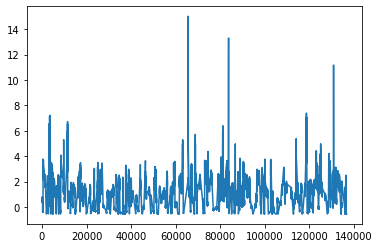

In [ ]:
 plt.plot(bay_area_monthly_elec_pge_nrel['TOTALKWH_std'])
#keep this plot!! shows why we got rid of the data (and make prettier)
 #plt.plot(bay_area_monthly_elec_pge_nrel_clean['TOTALKWH_std']) #add this plot to it side by side to show
 

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TOTALKWH_std', ylabel='Density'>

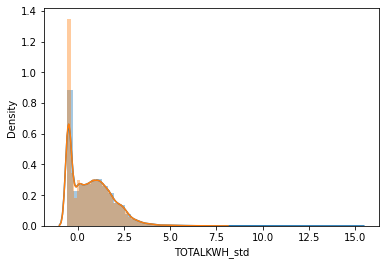

In [ ]:
sns.distplot(bay_area_monthly_elec_pge_nrel['TOTALKWH_std'])
sns.distplot(bay_area_monthly_elec_pge_nrel_clean['TOTALKWH_std'])


In [ ]:
## Trainv-validation split 
X_train, X_val, y_train, y_val = train_test_split(elec_X_train,elec_Y_train,test_size=0.2,
                                                  random_state=0)



In [ ]:
info(X_train)

Type:  <class 'pandas.core.frame.DataFrame'>
Shape:  (23136, 23)
Columns:  Index(['MONTH', 'YEAR', 'AVERAGEKWH_raw lag l=1', 'GHI_raw lag l=1',
       'DHI_raw lag l=1', 'DNI_raw lag l=1', 'Wind Speed lag l=1',
       'Temperature_raw lag l=1', 'Solar_Zenith_Angle_raw lag l=1',
       'AVERAGEKWH_raw lag l=2', 'GHI_raw lag l=2', 'DHI_raw lag l=2',
       'DNI_raw lag l=2', 'Wind Speed lag l=2', 'Temperature_raw lag l=2',
       'Solar_Zenith_Angle_raw lag l=2', 'AVERAGEKWH_raw lag l=3',
       'GHI_raw lag l=3', 'DHI_raw lag l=3', 'DNI_raw lag l=3',
       'Wind Speed lag l=3', 'Temperature_raw lag l=3',
       'Solar_Zenith_Angle_raw lag l=3'],
      dtype='object')


,MONTH,YEAR,AVERAGEKWH_raw lag l=1,GHI_raw lag l=1,DHI_raw lag l=1,DNI_raw lag l=1,Wind Speed lag l=1,Temperature_raw lag l=1,Solar_Zenith_Angle_raw lag l=1,AVERAGEKWH_raw lag l=2,...,Wind Speed lag l=2,Temperature_raw lag l=2,Solar_Zenith_Angle_raw lag l=2,AVERAGEKWH_raw lag l=3,GHI_raw lag l=3,DHI_raw lag l=3,DNI_raw lag l=3,Wind Speed lag l=3,Temperature_raw lag l=3,Solar_Zenith_Angle_raw lag l=3
20008,12,2014,0.0,110.697222,34.406944,183.043056,1.852500,13.701389,104.182097,0.0,...,1.835484,17.622312,96.956559,0.0,216.601389,63.559722,253.144444,1.744444,18.408333,87.993903
8451,6,2013,1167.0,314.283602,70.405914,359.475806,3.526210,15.475806,75.501868,1090.0,...,3.116944,13.383333,82.233444,1133.0,202.311828,68.474462,234.236559,2.175403,10.440860,91.107675
6987,2,2019,1017.0,94.188172,36.360215,144.482527,1.969355,10.159409,105.581774,1120.0,...,1.743011,9.150941,107.330094,947.0,120.838889,36.163889,202.102778,1.850000,13.312083,104.075958
11767,10,2016,0.0,149.538978,44.819892,208.764785,2.316801,16.020161,97.074960,0.0,...,3.045139,19.136111,88.153444,0.0,242.236111,58.045833,318.997222,3.045139,19.136111,88.153444
6281,2,2015,448.0,112.368280,36.229839,193.422043,2.377823,11.928763,105.554032,442.0,...,3.945027,13.077957,107.291452,371.0,113.693056,38.620833,181.026389,2.644028,14.772222,104.037292


### Simple Linear Regression

$$ \hat{\vec{y}} = \hat{\vec\beta}*\vec{x}$$

Coefficients in $ \hat{\vec\beta}$  are simply scalars that are fit to the best-fit line. That is, simply solving least squares

$$ \hat{\vec\beta} = (X^TX)^{-1}X^TY$$


In [ ]:
lm = LinearRegression() #linear regression
lm.fit(X_train, y_train)

## apply model to training data
lm_train_pred = lm.predict(X_train)
lm_train_mse = mean_squared_error(y_true=y_train, y_pred=lm_train_pred)

## apply model to test data
lm_test_pred = lm.predict(X_val)
lm_test_mse = mean_squared_error(y_true=y_val, y_pred=lm_test_pred)
print("Training MSE", lm_train_mse)
print("Testing MSE", lm_test_mse)

Training MSE 11512.800185165353
Testing MSE 12299.512755658488


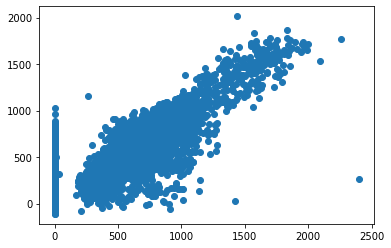

In [ ]:
plt.scatter(y_train, lm_train_pred)

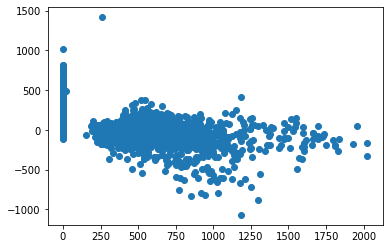

In [ ]:
plt.scatter(y_val, lm_test_pred-y_val)

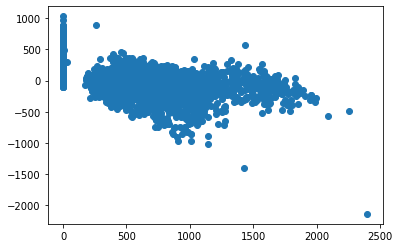

In [ ]:
plt.scatter(y_train, lm_train_pred-y_train)

In [ ]:
# sns.lineplot()


20008       0
8451     1325
6987      912
11767       0
6281      344
Name: AVERAGEKWH_raw, dtype: int64

In [ ]:
svr_regr = svm.SVR() #vector regression
svr_regr.fit(X_train, y_train)

SVR()

In [ ]:
## apply model to training data
svr_train_pred = svr_regr.predict(X_train)
svr_train_mse = mean_squared_error(y_true=y_train, y_pred=svr_train_pred)

## apply model to test data
svr_test_pred = svr_regr.predict(X_val)
svr_test_mse = mean_squared_error(y_true=y_val, y_pred=svr_test_pred)
print("Training MSE", svr_train_mse)
print("Testing MSE", svr_test_mse)

Training MSE 17615.813527959097
Testing MSE 19431.65061838336


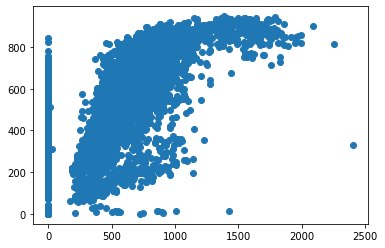

In [ ]:
plt.scatter(y_train, svr_train_pred)

### Decision Tree Regression Model

In [ ]:
X_train.head()

,MONTH,YEAR,zip,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw
73651,8,2019,94553,310.8225806451613,52.57258064516129,390.7110215053763,3.478360215053763,21.969758,79.630511
105904,3,2016,94940,169.7701612903226,59.166666666666664,192.32930107526883,4.809543010752688,12.182796,91.029530
12682,5,2013,95041,319.7204301075269,70.51344086021506,356.9623655913978,1.1791666666666678,14.376344,75.661573
50030,2,2015,94038,142.48958333333334,42.811011904761905,209.26934523809524,3.3116071428571443,13.616071,99.641830
14991,3,2018,95017,176.4959677419355,59.86021505376344,205.48924731182797,3.0182795698924756,11.216667,91.141855


In [ ]:
dtree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [ ]:
## apply model to training data
dtree_train_pred = dtree.predict(X_train)
dtree_train_mse = mean_squared_error(y_true=y_train, y_pred=dtree_train_pred)

## apply model to test data
dtree_test_pred = dtree.predict(X_val)
dtree_test_mse = mean_squared_error(y_true=y_val, y_pred=dtree_test_pred)
print("Training MSE", dtree_train_mse)
print("Testing MSE", dtree_test_mse)

Training MSE 22361.924219788987
Testing MSE 24123.35503044352


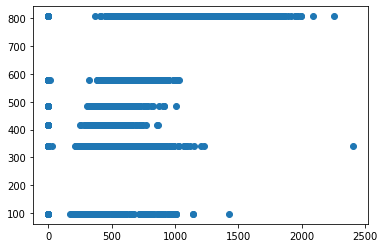

In [ ]:
plt.scatter(y_train, dtree_train_pred)

In [ ]:
### Standardized SVR

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('svr', svm.SVR())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [ ]:
pipe.score(X_val, y_val)

0.0691449342717636

In [ ]:
pipe.score(X_train, y_train)

0.08866927190156293

## KNN (K Nearest Neighbors)

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=2)

In [ ]:
neigh_train_pred = neigh.predict(X_train)
neigh_test_pred = neigh.predict(X_val)


NameError: name 'neigh' is not defined

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
print('Training MSE: ', mean_squared_error(neigh_train_pred, y_train))
print('Testing MSE: ', mean_squared_error(neigh_test_pred, y_test))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2f0e727-e6a4-4b2a-b180-a91c3a609ecf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>